<a href="https://colab.research.google.com/github/fjadidi2001/Machine_Learning_Journey/blob/main/BuildingDecisionTreeAlgorithmsinPython.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

> Creating a decision tree manually (without libraries like scikit-learn) requires implementing the following steps:



# step 1: Calculate Entropy:

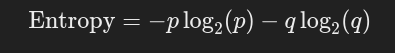

# step 2: Calculate Information Gain:

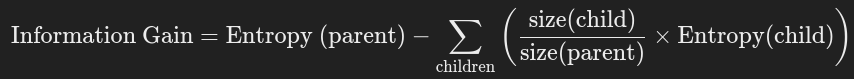

# step 3: Recursive Splitting:

> Starting from the root node, select the best feature, split the data, and repeat for each subset until reaching a stopping criterion, like zero entropy or a maximum depth.


In [2]:
import math
from collections import Counter

# Calculate entropy
def entropy(labels):
    label_count = Counter(labels)
    total_count = len(labels)
    entropy_value = 0.0
    for label, count in label_count.items():
        probability = count / total_count
        entropy_value -= probability * math.log2(probability)
    return entropy_value

# Split dataset
def split_dataset(dataset, feature_index, value):
    left_split = [row for row in dataset if row[feature_index] == value]
    right_split = [row for row in dataset if row[feature_index] != value]
    return left_split, right_split

# Calculate information gain
def information_gain(parent, left_child, right_child):
    total_count = len(parent)
    parent_entropy = entropy([row[-1] for row in parent])
    left_entropy = entropy([row[-1] for row in left_child])
    right_entropy = entropy([row[-1] for row in right_child])

    weighted_entropy = (len(left_child) / total_count) * left_entropy + (len(right_child) / total_count) * right_entropy
    return parent_entropy - weighted_entropy

# Find the best split
def best_split(dataset):
    best_gain = 0
    best_feature = None
    best_splits = None
    n_features = len(dataset[0]) - 1  # exclude label

    for feature_index in range(n_features):
        unique_values = set(row[feature_index] for row in dataset)
        for value in unique_values:
            left_split, right_split = split_dataset(dataset, feature_index, value)
            if not left_split or not right_split:
                continue
            gain = information_gain(dataset, left_split, right_split)
            if gain > best_gain:
                best_gain = gain
                best_feature = (feature_index, value)
                best_splits = (left_split, right_split)

    return best_feature, best_splits

# Build the decision tree
def build_tree(dataset, depth=0, max_depth=5):
    labels = [row[-1] for row in dataset]
    if labels.count(labels[0]) == len(labels) or depth == max_depth:
        return Counter(labels).most_common(1)[0][0]  # return the most common label

    feature, splits = best_split(dataset)
    if feature is None:
        return Counter(labels).most_common(1)[0][0]

    left_branch = build_tree(splits[0], depth + 1, max_depth)
    right_branch = build_tree(splits[1], depth + 1, max_depth)

    return {f"Feature_{feature[0]} = {feature[1]}": {"Yes": left_branch, "No": right_branch}}

# Prediction function
def predict(tree, row):
    if not isinstance(tree, dict):
        return tree
    for key, branches in tree.items():
        feature_index, value = int(key.split("_")[1].split(" ")[0]), key.split("= ")[1]
        if row[feature_index] == value:
            return predict(branches["Yes"], row)
        else:
            return predict(branches["No"], row)

# Evaluate accuracy
def evaluate(tree, dataset):
    correct = 0
    for row in dataset:
        prediction = predict(tree, row)
        if prediction == row[-1]:
            correct += 1
    return correct / len(dataset)

# Visualize the decision tree
def print_tree(tree, depth=0):
    if not isinstance(tree, dict):
        print("\t" * depth + f"Leaf: {tree}")
        return
    for key, branches in tree.items():
        print("\t" * depth + str(key))
        print("\t" * (depth + 1) + "Yes:")
        print_tree(branches["Yes"], depth + 2)
        print("\t" * (depth + 1) + "No:")
        print_tree(branches["No"], depth + 2)

# Sample dataset: [Outlook, Humidity, Wind, PlayTennis]
dataset = [
    ['Sunny', 'High', 'Weak', 'No'],
    ['Sunny', 'High', 'Strong', 'No'],
    ['Overcast', 'High', 'Weak', 'Yes'],
    ['Rain', 'High', 'Weak', 'Yes'],
    ['Rain', 'Normal', 'Weak', 'Yes'],
    ['Rain', 'Normal', 'Strong', 'No'],
    ['Overcast', 'Normal', 'Strong', 'Yes'],
    ['Sunny', 'High', 'Weak', 'No'],
    ['Sunny', 'Normal', 'Weak', 'Yes'],
    ['Rain', 'Normal', 'Weak', 'Yes'],
    ['Sunny', 'Normal', 'Strong', 'Yes'],
    ['Overcast', 'High', 'Strong', 'Yes'],
    ['Overcast', 'Normal', 'Weak', 'Yes'],
    ['Rain', 'High', 'Strong', 'No']
]

# Building the tree
tree = build_tree(dataset)

# Visualizing the tree
print("Decision Tree Structure:")
print_tree(tree)

# Evaluating the tree
accuracy = evaluate(tree, dataset)
print("\nAccuracy:", accuracy)


Decision Tree Structure:
Feature_0 = Overcast
	Yes:
		Leaf: Yes
	No:
		Feature_1 = Normal
			Yes:
				Feature_2 = Strong
					Yes:
						Feature_0 = Rain
							Yes:
								Leaf: No
							No:
								Leaf: Yes
					No:
						Leaf: Yes
			No:
				Feature_0 = Rain
					Yes:
						Feature_2 = Strong
							Yes:
								Leaf: No
							No:
								Leaf: Yes
					No:
						Leaf: No

Accuracy: 1.0


In [7]:
# New data for testing
new_data = [
    ['Sunny', 'High', 'Weak', 'No'],    # Known example
    ['Sunny', 'Normal', 'Weak', 'Yes'], # Known example
    ['Rain', 'Normal', 'Strong', 'No'], # Known example
    ['Overcast', 'High', 'Weak', 'Yes'],# Known example
    ['Sunny', 'High', 'Strong', 'No'],  # Known example
    # New unseen examples
    ['Rain', 'High', 'Weak', 'Yes'],
    ['Sunny', 'Normal', 'Strong', 'Yes'],
    ['Overcast', 'Normal', 'Strong', 'Yes'],
    ['Rain', 'High', 'Strong', 'No']
]

# Evaluate the model on the new dataset
def evaluate_new_data(tree, new_data):
    correct = 0
    for row in new_data:
        prediction = predict(tree, row)
        print(f"Predicted: {prediction}, Actual: {row[-1]}")
        if prediction == row[-1]:
            correct += 1
    accuracy = correct / len(new_data)
    print("\nAccuracy on new data:", accuracy)

# Running the evaluation
print("Evaluating on new data:")
evaluate_new_data(tree, new_data)


Evaluating on new data:
Predicted: No, Actual: No
Predicted: Yes, Actual: Yes
Predicted: No, Actual: No
Predicted: Yes, Actual: Yes
Predicted: No, Actual: No
Predicted: Yes, Actual: Yes
Predicted: Yes, Actual: Yes
Predicted: Yes, Actual: Yes
Predicted: No, Actual: No

Accuracy on new data: 1.0
